# Results:

This notebook is used to analyze the results of the tests.

First, a few imports and global variables:

In [285]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
RESULTS_PATH = './results/'
TESTS = ['test_1', 'test_3']
EXTENSION = '.json'

# Test 1:

We extract the data in json to a pandas dataframe with the first experiment results:

In [2]:
with open(RESULTS_PATH + TESTS[0] + EXTENSION) as f:
    test_1 = json.load(f)[TESTS[0]]
df_t1 = pd.DataFrame(test_1)
# Replace -1e9 in best_fit for +1e9 in order to compute the score:
df_t1['best_fit'] = df_t1['best_fit'].replace(-1_000_000, 1_000_000)
# Print the first rows:
df_t1.head(None)
# Drop where function = HolderTableFunction:
df_t1 = df_t1[df_t1['function'] != 'HolderTableFunction']

We compute the scores based on the performance of the best algorithm in each dimension and function:

Now, we compute the score of performance for each dimension and function:

The score of the algorithm respect to the dimension and function is 0 if in minimum and 1 if in maximum, in linear scale.

In [3]:
df = df_t1
# Calculate the minimum and maximum fitness for each algorithm, function, and dimension group
grouped = df.groupby(['algorithm', 'function', 'dimension'])['best_fit']
min_fitness = grouped.min().groupby(['algorithm', 'function']).min()
max_fitness = grouped.max().groupby(['algorithm', 'function']).max()
# Merge the calculated minimum and maximum fitness back to the original DataFrame
df = df.merge(min_fitness, on=['algorithm', 'function'], suffixes=('', '_min'))
df = df.merge(max_fitness, on=['algorithm', 'function'], suffixes=('', '_max'))
# Calculate the score using the provided formula
df['score'] = 1 - (df['best_fit'] - df['best_fit_min']) / (df['best_fit_max'] - df['best_fit_min'])
# Drop the redundant columns if needed
df.drop(['best_fit_min', 'best_fit_max'], axis=1, inplace=True)
# Export as csv:
df.to_csv('./results/test_1.csv', index=False)

We get the results according to the dimension and function by terms of means and plot the results in seaborn as a line plot:

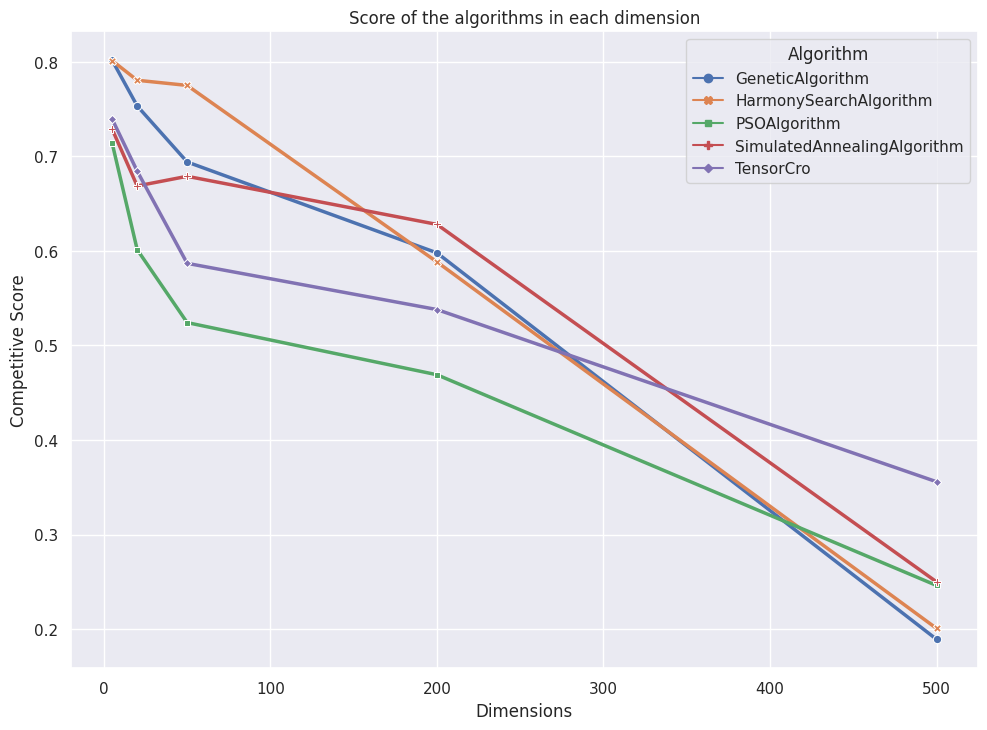

In [4]:
new_df = df.groupby(['algorithm', 'dimension']).mean(numeric_only=True)
new_df.reset_index(inplace=True)
new_df.head(None)

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.lineplot(data=new_df, x="dimension", y="score", hue="algorithm", style="algorithm", markers=True, dashes=False, linewidth=2.5)
# Labels of the sns plot:
fig.set(xlabel='Dimensions', ylabel='Competitive Score')
fig.set_title('Score of the algorithms in each dimension')
fig.legend(title='Algorithm')
fig.figure.savefig('./results/test_1.png')

# Test 3:

We extract the data in json to a pandas dataframe with the second experiment results (GPU vs CPU):

best_fit  elapsed_time    seed       num_eval
dimension algorithm                                                          
5         TensorCRO:/CPU:0  3.099738e+05    300.079015  2026.0  156617.238095
          TensorCRO:/GPU:0  3.106461e+05    300.077971  2026.0   88672.209524
20        TensorCRO:/CPU:0  1.790014e+07    300.078413  2026.0  142162.666667
          TensorCRO:/GPU:0  1.790006e+07    300.079010  2026.0   81926.095238
50        TensorCRO:/CPU:0  6.666462e+07    300.086791  2026.0   90147.066667
          TensorCRO:/GPU:0  6.666456e+07    300.089946  2026.0   57554.542857
200       TensorCRO:/CPU:0  6.666029e+07    300.098889  2026.0   25195.771429
          TensorCRO:/GPU:0  6.666032e+07    300.113225  2026.0   21043.733333
350       TensorCRO:/CPU:0  6.665657e+07    300.128548  2026.0    9029.533333
          TensorCRO:/GPU:0  6.665638e+07    300.132896  2026.0   12669.457143
500       TensorCRO:/CPU:0  6.665409e+07    300.116197  2026.0    4450.571429
          TensorCRO:/GPU:0  6.665323e+07    300.100489  2026.0    9589.904762

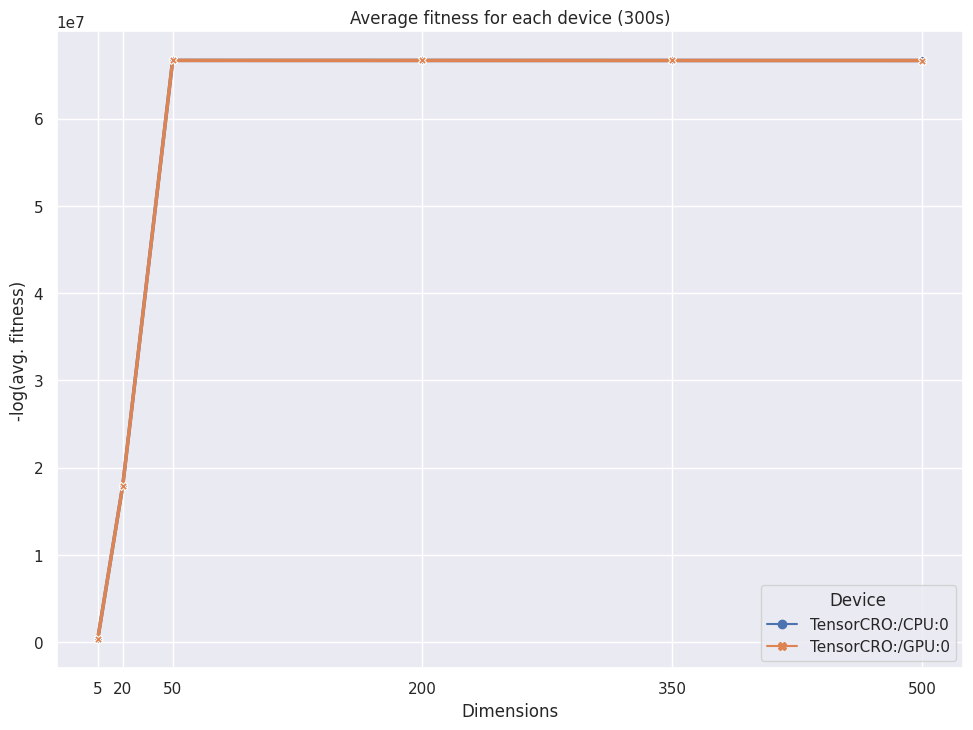

In [337]:
with open(RESULTS_PATH + TESTS[1] + EXTENSION) as f:
    test_2 = json.load(f)[TESTS[1]]
df_t2 = pd.DataFrame(test_2)
# Replace -1e9 in best_fit for +1e9 in order to compute the score:
df_t2['best_fit'] = df_t2['best_fit'].replace(-1_000_000, 1_000_000)
# Filter seed under 2025:
df_t2 = df_t2[df_t2['seed'] < 2030]
# Drop where function = HolderTableFunction:
df_t2 = df_t2[df_t2['function'] != 'HolderTableFunction']
# Export to csv:
df_t2.to_csv('./results/test_3.csv', index=False)
# Group by algorithm and dimension:
new_df = df_t2.groupby(['dimension', 'algorithm']).mean(numeric_only=True)
# Plot CPU and GPU for each dimension:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.lineplot(data=new_df, x="dimension", y="best_fit", hue="algorithm", style="algorithm", markers=True, dashes=False, linewidth=2.5)
# Labels of the sns plot:
fig.set(xlabel='Dimensions', ylabel='-log(avg. fitness)')
fig.set_title('Average fitness for each device (300s)')
fig.legend(title='Device')
fig.set_xticks(df_t2['dimension'].unique())
fig.figure.savefig('./results/test_3.png')
new_df.head(None)

/tmp/ipykernel_4534/944602272.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for gp in new_df.groupby(['dimension']):


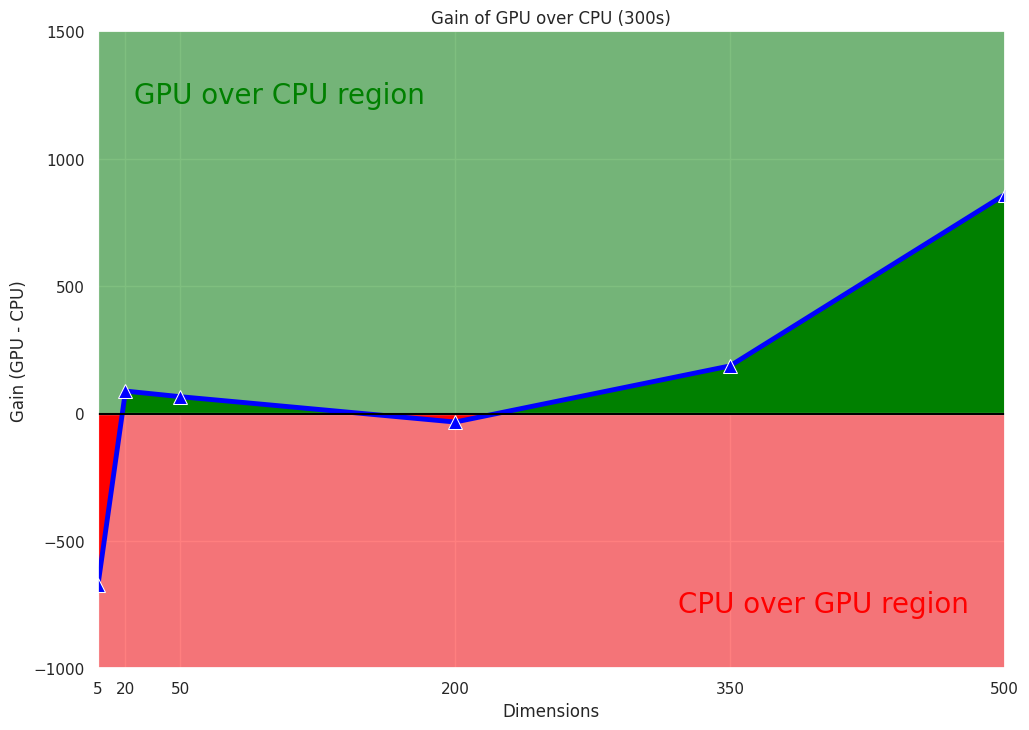

In [338]:
# Compute lines:
last_fit = None
carrier = list()
for gp in new_df.groupby(['dimension']):
    for idx, fit in enumerate(gp[1]['best_fit']):
        if idx % 2 == 1:
            carrier.append((gp[0], last_fit - fit))
        else:
            last_fit = fit
performance = np.array(carrier)
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
axis = np.array(performance[:, 0], dtype=np.int32)

# Plot the line:
fig = sns.lineplot(data=performance, x=performance[:,0], y=performance[:,1], linewidth=3.5, marker='^', markersize=10, color='blue')
# Plot a line in the zero axis:
fig.axhline(0, ls='-', color='black')
# Fill between the line and the zero axis:
fig.fill_between(axis, performance[:,1], 0, where=performance[:,1] >= 0, facecolor='green', interpolate=True, alpha=1)
fig.fill_between(axis, performance[:,1], 0, where=performance[:,1] <= 0, facecolor='red', interpolate=True, alpha=1)
# Fill green from 2000 to 0 (y-axis) independent of the performance:
fig.fill_between(axis, 20000, 0, facecolor='green', interpolate=True, alpha=0.5)
fig.fill_between(axis, -20000, 0, facecolor='red', interpolate=True, alpha=0.5)
# Add text to the plot:
fig.text(0.2, 0.9, 'GPU over CPU region', fontsize=20, color='green', horizontalalignment='center', verticalalignment='center', transform=fig.transAxes)
fig.text(0.8, 0.1, 'CPU over GPU region', fontsize=20, color='red', horizontalalignment='center', verticalalignment='center', transform=fig.transAxes)


# Boxplot:
# violin_df = df_t2.groupby(['dimension', 'seed', 'algorithm']).mean(numeric_only=True)
# # Substract CPU values to GPU values:
# violin_df['diff'] = - violin_df['best_fit'] + violin_df['best_fit'].shift(1)
# violin_df['diff_eval'] = violin_df['num_eval'] - violin_df['num_eval'].shift(1)
# # Get only algorithm TensorCRO:/GPU:0 (index 1)
# diff_df = violin_df['diff'].groupby(['dimension', 'seed']).last().reset_index()
# diff_eval_df = violin_df['diff_eval'].groupby(['dimension', 'seed']).last().reset_index()
# # To numpy array:
# diff_df = diff_df.to_numpy()
# diff_eval_df = diff_eval_df.to_numpy()
# # Violin over previous figure:
# fig = sns.boxplot(x=np.array(diff_df[:, 0], dtype=np.int32), y=diff_df[:, 2], linewidth=1, color='blue', boxprops=dict(alpha=.3))

# xlim between 0 and 2000:
fig.set_xlim(5, 500)
# ylim between -20000 and 20000:
fig.set_ylim(-1000, 1500)
# Labels of the sns plot:
fig.set(xlabel='Dimensions', ylabel='Gain (GPU - CPU)')
fig.set_title('Gain of GPU over CPU (300s)')
fig.set_xticks(df_t2['dimension'].unique())
fig.figure.savefig('./results/test_3_performance.png')

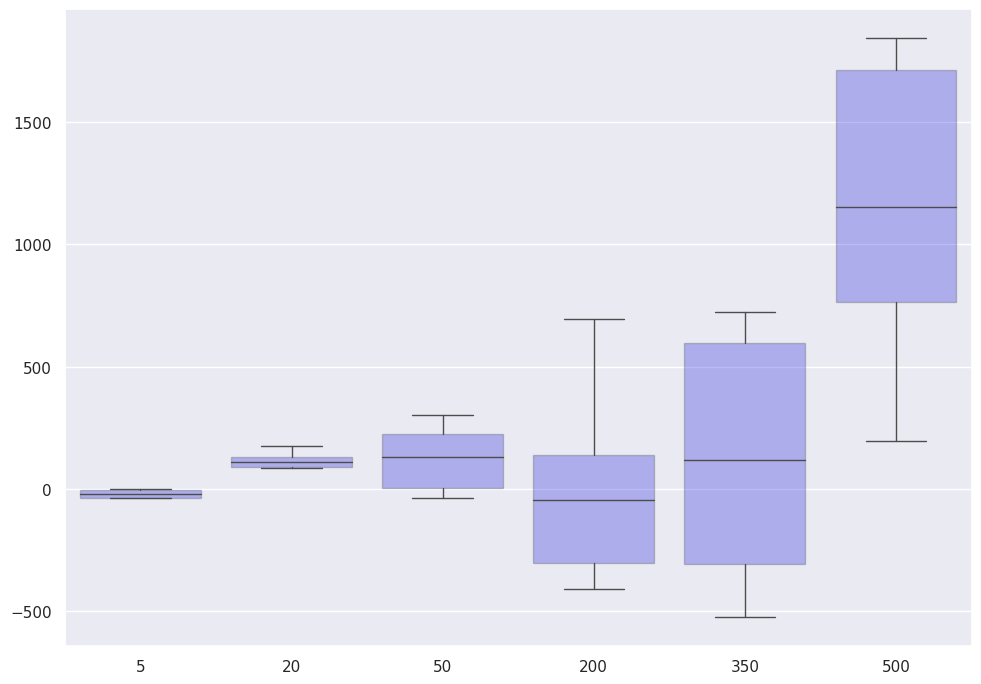

In [332]:
violin_df = df_t2.groupby(['dimension', 'seed', 'algorithm']).mean(numeric_only=True)
# Substract CPU values to GPU values:
violin_df['diff'] = - violin_df['best_fit'] + violin_df['best_fit'].shift(1)
violin_df['diff_eval'] = violin_df['num_eval'] - violin_df['num_eval'].shift(1)
# Get only algorithm TensorCRO:/GPU:0 (index 1)
diff_df = violin_df['diff'].groupby(['dimension', 'seed']).last().reset_index()
diff_eval_df = violin_df['diff_eval'].groupby(['dimension', 'seed']).last().reset_index()
# To numpy array:
diff_df = diff_df.to_numpy()
diff_eval_df = diff_eval_df.to_numpy()
# Substitute dimension values for integer ticks:
# Violin over previous figure:
fig = sns.boxplot(x=np.array(diff_df[:, 0], dtype=np.int32), y=diff_df[:, 2], linewidth=1, color='blue', boxprops=dict(alpha=.3), showfliers=False)

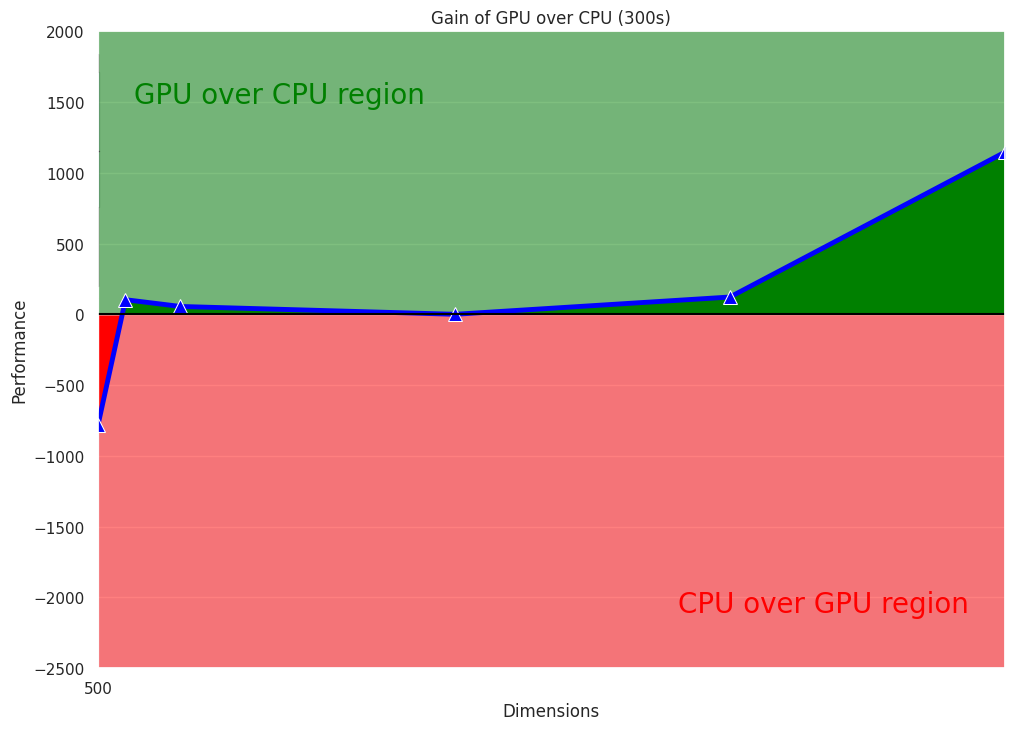

In [333]:
# Stack performance and boxplots:
fig = sns.lineplot(data=performance, x=performance[:,0], y=performance[:,1], linewidth=3.5, marker='^', markersize=10, color='blue')
# Plot a line in the zero axis:
fig.axhline(0, ls='-', color='black')
# Fill between the line and the zero axis:
fig.fill_between(axis, performance[:,1], 0, where=performance[:,1] >= 0, facecolor='green', interpolate=True, alpha=1)
fig.fill_between(axis, performance[:,1], 0, where=performance[:,1] <= 0, facecolor='red', interpolate=True, alpha=1)
# Fill green from 2000 to 0 (y-axis) independent of the performance:
fig.fill_between(axis, 20000, 0, facecolor='green', interpolate=True, alpha=0.5)
fig.fill_between(axis, -20000, 0, facecolor='red', interpolate=True, alpha=0.5)
# Add text to the plot:
fig.text(0.2, 0.9, 'GPU over CPU region', fontsize=20, color='green', horizontalalignment='center', verticalalignment='center', transform=fig.transAxes)
fig.text(0.8, 0.1, 'CPU over GPU region', fontsize=20, color='red', horizontalalignment='center', verticalalignment='center', transform=fig.transAxes)
# Violin over previous figure:
fig = sns.boxplot(x=np.array(diff_df[:, 0], dtype=np.int32), y=diff_df[:, 2], linewidth=1, color='blue', boxprops=dict(alpha=.3))
# xlim between 0 and 2000:
fig.set_xlim(5, 500)
# ylim between -20000 and 20000:
fig.set_ylim(-1000, 1500)
# Labels of the sns plot:
fig.set(xlabel='Dimensions', ylabel='Performance')
fig.set_title('Gain of GPU over CPU (300s)')
fig.set_xticks(df_t2['dimension'].unique())